## Practical Introduction to Transformer Models: BERT

In the field of NLP, the transformer model architecture has been a revolutionary discovery that greatly enhanced our ability to understand and generate human language.

This tutorial provides a close look at BERT (Bidirectional Encoder Representations from Transformers), one of the most popular transformer-based models, and instructs on its use in practice for sentiment analysis by fine-tuning the base model.

#### Introduction to BERT
BERT, introduced by researchers at Google in 2018, is a powerful language model that uses transformer architecture. What sets BERT apart is its bidirectional nature. Traditional language models like LSTM and GRU are either unidirectional or sequentially bidirectional, but BERT takes into account the context from both past and future words simultaneously for a specific word. The key innovation in the transformer model is the "attention" mechanism, which allows the model to weight the importance of different words in a sentence when generating representations.
This feature allows BERT to understand the complete context of a word and, consequently, produce more accurate language models. It is pre-trained on two NLP tasks:
- Masked Language Model (MLM) and 
- Next Sentence Prediction (NSP), 

and is often used as a starting point for various downstream NLP tasks, like sentiment analysis, which will be explored in this tutorial.

#### Pre-Training and Fine-Tuning
The power of BERT comes from its two-step process: 
- Pre-training is the phase where BERT is trained on large amounts of data. As a result, it learns to predict masked words in a sentence (MLM task) and to predict if a sentence follows another one (NSP task). The output of this stage is a a pre-trained NLP model with a general-purpose "understanding" of the language
- Fine-tuning is where the pre-trained BERT model is further trained on a specific task. The model is initialized with the pre-trained parameters, and the entire model is trained on a downstream task, allowing BERT to fine-tune its understanding of language to the specifics of the task at hand.

#### Hands On: Using BERT for sentiment analysis
Now, let's get our hands dirty. We're going to perform sentiment analysis on the IMDb dataset, which contains movie reviews labeled as either positive or negative. For this, we'll be using Hugging Face's transformers library.

** **
Let's load all the libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Variables to set the number of epochs and samples
num_epochs = 10
num_samples = 100  # set this to -1 to use all data

/Users/skapadia/Library/Caches/pypoetry/virtualenvs/transformers-models-r2uefcSj-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


** **
First, we need to load the dataset and the model tokenizer.

In [2]:
# Step 1: Load dataset and model tokenizer
dataset = load_dataset('imdb')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Found cached dataset imdb (/Users/skapadia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 385.36it/s]


** **
Before we move on, let's explore our dataset a bit. We'll create a plot to see the distribution of the positive and negative classes.

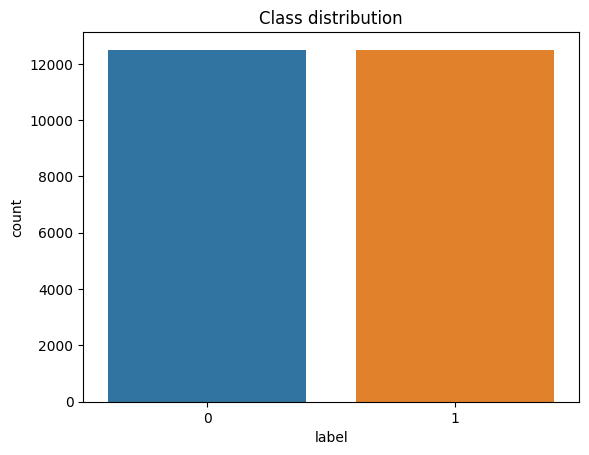

In [3]:
# Data Exploration
train_df = pd.DataFrame(dataset["train"])
sns.countplot(x='label', data=train_df)
plt.title('Class distribution')
plt.show()

It is essential to highlight that in practical applications, encountering a balanced class distribution is rarely the case. If the dataset for your use-case demonstrates class imbalance, it is strongly recommended to implement suitable strategies prior to training the model. Such procedures can significantly enhance the model's performance.

** **
Next, we preprocess our dataset by tokenizing the texts. We use BERT's tokenizer, which will convert the text into tokens that correspond to BERT's vocabulary.

In [4]:
# Step 2: Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /Users/skapadia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-8d3f672c6bd459c5.arrow
Loading cached processed dataset at /Users/skapadia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a224c74dea2a378a.arrow
Loading cached processed dataset at /Users/skapadia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-3771e6c862b361d6.arrow


** **
After that, we prepare our training and evaluation datasets. Remember, if you want to use all the data, you can set the num_samples variable to -1.

In [5]:
if num_samples == -1:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)
else:
    small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(num_samples)) 
    small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(num_samples))

Loading cached shuffled indices for dataset at /Users/skapadia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-84712cace8bef640.arrow
Loading cached shuffled indices for dataset at /Users/skapadia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-89ec35fd52b28a4f.arrow


** **
Then, we load the pre-trained BERT model. We'll use the AutoModelForSequenceClassification class, a BERT model designed for classification tasks.

For this tutorial, we use the 'bert-base-uncased' version of BERT, which is trained on lower-case English text, is used for this tutorial.

In [6]:
# Step 3: Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

** **
Now, we're ready to define our training arguments and create a Trainer instance to train our model.

In [7]:
# Step 4: Define training arguments
training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch", no_cuda=True, num_train_epochs=num_epochs)

# Step 5: Create Trainer instance and train
trainer = Trainer(
    model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset
)

trainer.train()

/Users/skapadia/Library/Caches/pypoetry/virtualenvs/transformers-models-r2uefcSj-py3.9/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.673399
2,No log,0.577147
3,No log,0.523433
4,No log,0.736292
5,No log,0.903130
6,No log,0.924082
7,No log,1.438573
8,No log,1.406258
9,No log,1.299035
10,No log,1.258621


TrainOutput(global_step=130, training_loss=0.1417579357440655, metrics={'train_runtime': 1018.0087, 'train_samples_per_second': 0.982, 'train_steps_per_second': 0.128, 'total_flos': 263111055360000.0, 'train_loss': 0.1417579357440655, 'epoch': 10.0})

** **
#### Interpreting Results
Having trained our model, let's evaluate it. We'll calculate the confusion matrix and the ROC curve to understand how well our model performs.

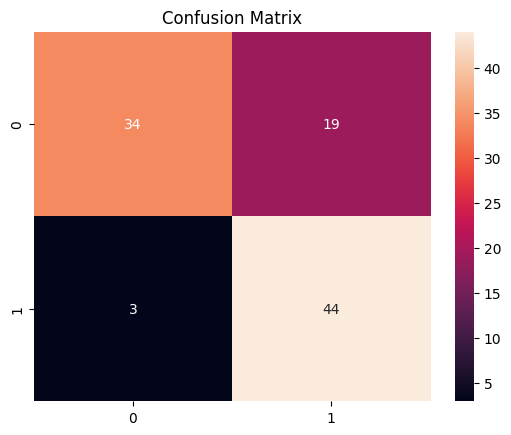

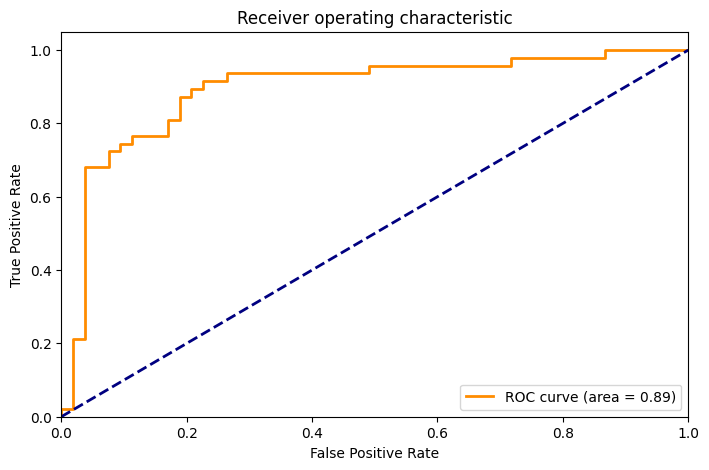

In [8]:
# Step 6: Evaluation
predictions = trainer.predict(small_eval_dataset)

# Confusion matrix
cm = confusion_matrix(small_eval_dataset['label'], predictions.predictions.argmax(-1))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(small_eval_dataset['label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(1.618 * 5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Interpreting these results calls for a basic understanding of evaluation metrics. 

The confusion matrix gives a detailed breakdown of how our predictions measure up to the actual labels, while the ROC curve shows us the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various threshold settings. The area under the ROC curve (AUC-ROC) is a measure of the overall performance of the model, with 1.0 representing perfect classification and 0.5 indicating a model no better than random guessing.
** **
Finally, to see our model in action, let's use it to infer the sentiment of a sample text.

In [9]:
# Step 7: Inference on a new sample
sample_text = "This is a fantastic movie. I really enjoyed it."
sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

# Move inputs to device (if GPU available)
sample_inputs.to(training_args.device)

# Make prediction
predictions = model(**sample_inputs)
predicted_class = predictions.logits.argmax(-1).item()

if predicted_class == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")

Positive sentiment


** **
#### Closing Thoughts
BERT represents an enormous leap forward in our ability to model and understand natural language. It's become a cornerstone for NLP tasks due to its superior handling of context within language. With this tutorial, my goal was to give you a practical introduction to BERT, detailing its basic theory and showing its application in Python using Hugging Face's transformers library.

By walking through an example of sentiment analysis on IMDb movie reviews, I hope you've gained a clear understanding of how to apply BERT to real-world NLP problems. The Python code I've included here can be adjusted and extended to tackle different tasks and datasets, paving the way for even more sophisticated and accurate language models.